# Predicting Leads To Customers

Project Description: https://youtrack.geox.ws/issue/CR-138

# Import Modules

In [1]:
import os
import sys
from credentials import *
sys.path.append(project_path)
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import seaborn as sns
import tensorflow as tf
import matplotlib as mpl
import missingno as msno
from tensorflow import keras
from matplotlib import colormaps
import matplotlib.pyplot as plt
from Queries.lead_queries import *
from urllib.request import urlopen
from ClassLibify.main import DataExtractor

# Options and Settings

In [2]:
warnings.simplefilter("ignore")
mpl.rcParams["axes.grid"] = False
rnd_seed = tf.random.set_seed(1234)
mpl.rcParams["figure.figsize"] = (8, 6)
np.set_printoptions(precision=4, suppress=True)
pd.options.plotting.matplotlib.register_converters = True

# Load Image

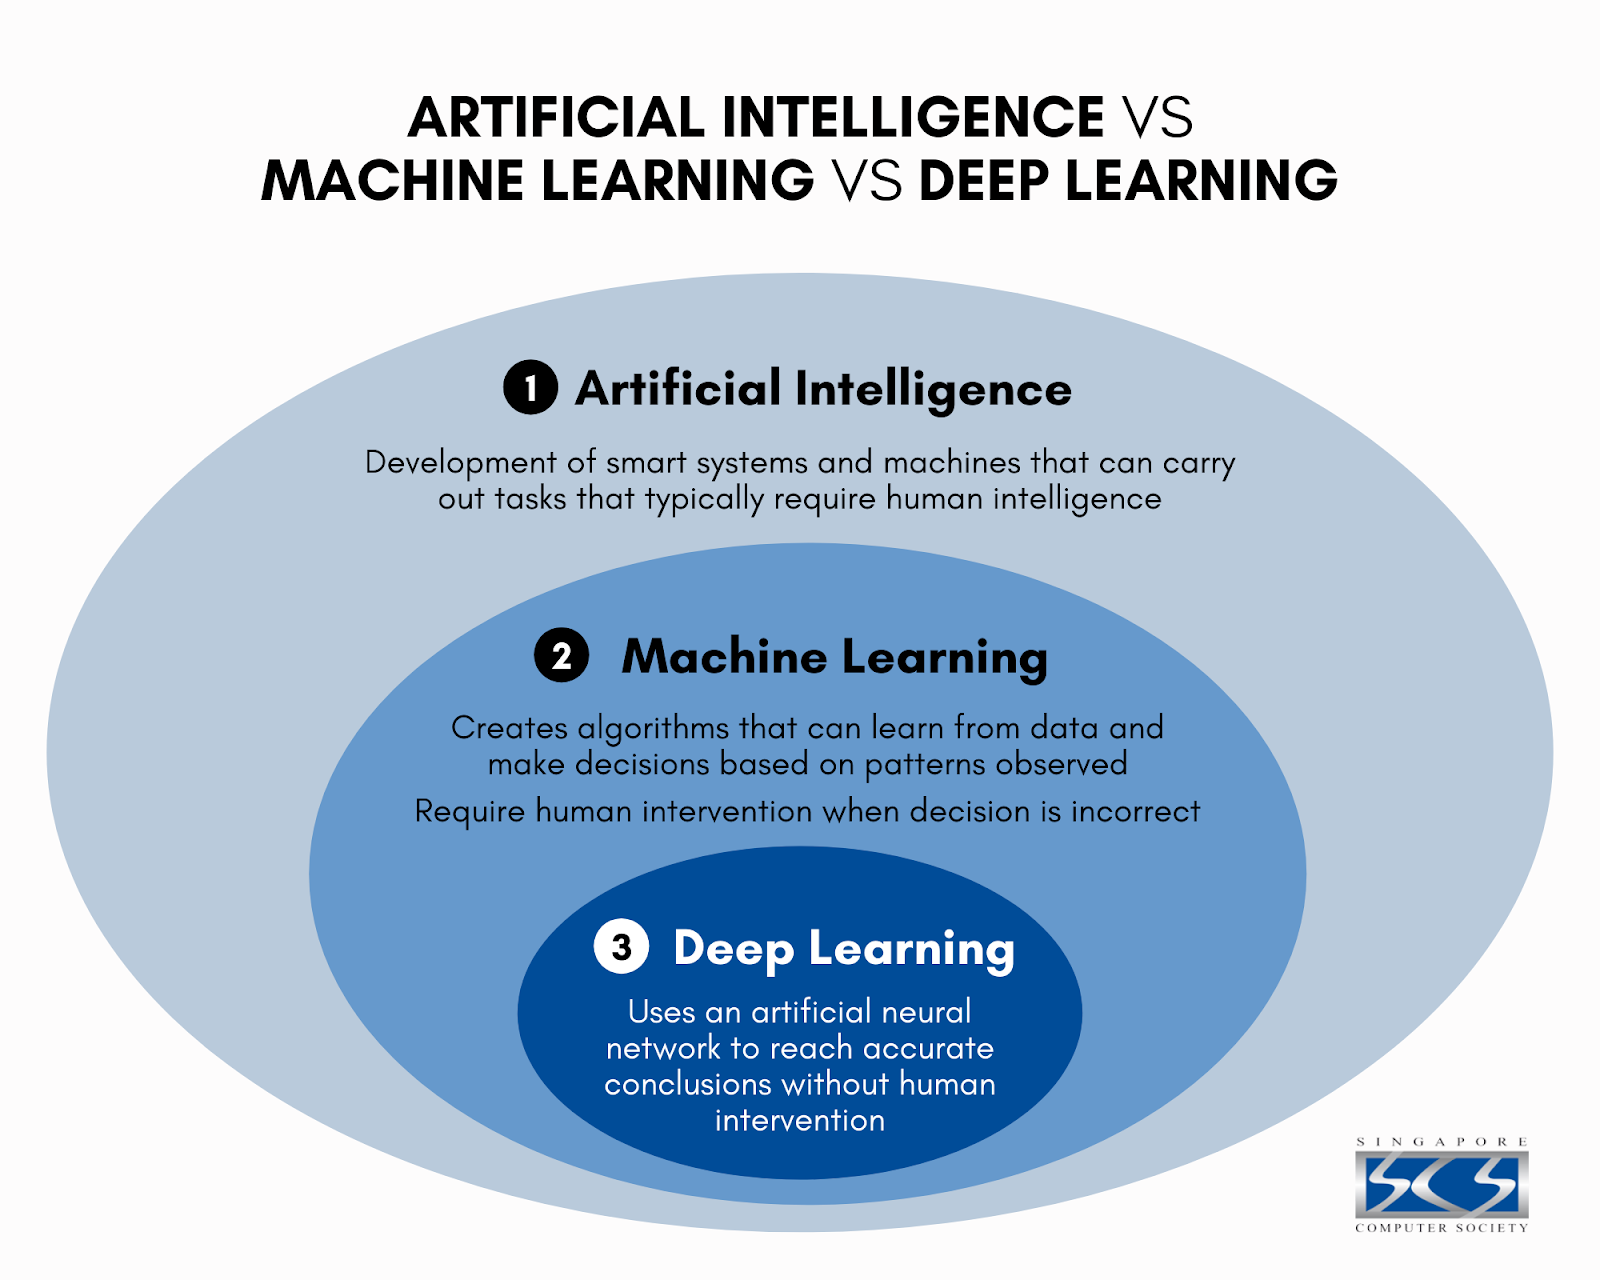

In [3]:
image_url = "https://s3.ap-southeast-1.amazonaws.com/files-scs-prod/public%2Fimages%2F1605842918803-AI+vs+ML+vs+DL.png"
Image.open(urlopen(image_url))

# Helper Functions

In [4]:
def fetch_db_data(sql_query: str, cols_to_use: list[str]):
  """
  Fetches data from Libify Databases

  Parameters
  ----------
  sql_query: str
    sql query to execute

  cols_to_use: list[str]
    list of column names to consider

  Returns:
      Pandas Dataframe

  """
  data = DataExtractor().get_data_repo_db(sql_query)

  return data[cols_to_use]



def min_max_scaler(df: pd.DataFrame, cols: str = list[str]):
  """
  Transform features by scaling each feature to a given range.

  Parameters
  ----------
  
  df: pd.DataFrame

  cols: str = list[str], defaults to list of strings
      column name or list of column names

  Returns:
      Transformed data.
      
  """
  return ( df[cols] - df[cols].min() ) / ( df[cols].max() - df[cols].min() ) 



def window_dataset(data, targets, start_index: bool = None, end_index: bool = None, batch_size: int = 256, **kwargs):
    """
    Creates a dataset of sliding windows over a timeseries provided as array.

    This function takes in a sequence of data-points gathered at equal intervals, along with time series parameters such as length of the sequences/windows, 
    spacing between two sequence/windows, etc., to produce batches of timeseries inputs and targets.

    Parameters
    ----------
    data:	Numpy array or eager tensor containing consecutive data points (timesteps). Axis 0 is expected to be the time dimension.
    
    targets: Targets corresponding to timesteps in data. targets[i] should be the target corresponding to the window that starts at 
              index i (see example 2 below). Pass None if you don't have target data (in this case the dataset will only yield the input data).
 
    start_index:	Optional int; data points earlier (exclusive) than start_index will not be used in the output sequences. 
                  This is useful to reserve part of the data for test or validation. Defaults to None

    end_index:	Optional int; data points later (exclusive) than end_index will not be used in the output sequences. 
              This is useful to reserve part of the data for test or validation. Defaults to None

    batch_size:	Number of timeseries samples in each batch (except maybe the last one). If None, the data will not be 
                batched (the dataset will yield individual samples).

    https://www.tensorflow.org/api_docs/python/tf/keras/utils/timeseries_dataset_from_array

    """
    dataset = keras.utils.timeseries_dataset_from_array(
                                                         data=data,
                                                         targets=targets,
                                                         batch_size=batch_size,
                                                         shuffle=True,
                                                         seed=1234,
                                                         start_index=start_index,
                                                         end_index=end_index,
                                                         **kwargs
                                                       )
    
    for samples, targets in dataset:
      # print("batch_size:", samples.shape[0])
      # print("timesteps:", samples.shape[1])
      # print("input_features:", samples.shape[2])
      # print("\n")
      print("samples shape:", samples.shape)
      print("targets shape:", targets.shape)
      break

    return np.float32(samples), np.float32(targets)



def model_pipeline(layers, optimizer, loss, metrics, x, y, validation_data, model_name, epochs: int = 10, **kwargs):
  """
  Pipeline for building, compiling and model fitting
    
  Parameters
  ----------
  layers: Optional list of layers to add to the model.
  
  optimizer: String (name of optimizer) or optimizer instance. See tf.keras.optimizers.

  loss: Loss function. May be a string (name of loss function), or a tf.keras.losses.Loss instance. See tf.keras.losses.
          metrics: List of metrics to be evaluated by the model during training and testing.

  x: Input data. 

  y: Output data.

  validation_data: data to evaluate trained model on

  model_name: name of the best saved model

  epochs: Number of epochs to train the model.

  use_multiprocessing: If True, use process-based threading.     

  Returns:
    A History object. Its History.history attribute is a record of training loss values and metrics values at successive epochs, 
      as well as validation loss values and validation metrics values 
           
  """
  model = keras.Sequential(layers=layers, **kwargs)

  model.compile(optimizer=optimizer, loss=loss, metrics=metrics, **kwargs)

  history = model.fit(x=x, y=y, validation_data=validation_data, epochs=epochs, callbacks=[keras.callbacks.ModelCheckpoint(f"{model_name}", save_best_only=True)], use_multiprocessing=True)
    
  return pd.DataFrame(history.history)



def plot_model_history(df: pd.DataFrame, metric_cols: list[str], **kwargs):
  """
  Plot model results

  Parameters
  ----------

  df: pd.DataFrame

  metric_cols: list of strings

  """
  return df[metric_cols].plot(**kwargs)



def evaluate_test_model(model_name: str, x=None, y=None):
  """
  Returns the loss value & metrics values for the model in test mode.

  Parameters
  ----------
  model_name: str
      Saved best model
      
  x: Input data. It could be:
        A NumPy array (or array-like), or a list of arrays (in case the model has multiple inputs).
        A tensor, or a list of tensors (in case the model has multiple inputs).
        A dict mapping input names to the corresponding array/tensors, if the model has named inputs.
        A tf.data.Dataset. Should return a tuple of either (inputs, targets) or (inputs, targets, sample_weights).
        A generator or keras.utils.PyDataset returning (inputs, targets) or (inputs, targets, sample_weights).
  
  y: Target data. Like the input data x, it could be either NumPy array(s) or backend-native tensor(s). 
        If x is a tf.data.Dataset or keras.utils.PyDataset instance, y should not be specified (since targets will be obtained from the iterator/dataset).

  Returns:
      Scalar test loss (if the model has a single output and no metrics) or list of scalars (if the model has multiple outputs and/or metrics). 
      The attribute model.metrics_names will give you the display labels for the scalar outputs.

  https://keras.io/api/models/model_training_apis/

  """
  best_model = keras.models.load_model(os.path.join(ml_output, f"{model_name}"))
  
  return best_model.evaluate(x, y)



def make_predictions(model_name: str, x=None):
  """
  Generates output predictions for the input samples.

  Parameters
  ----------
  model_name: str
      Saved best model
      
  x: Input samples. It could be:
        A NumPy array (or array-like), or a list of arrays (in case the model has multiple inputs).
        A tensor, or a list of tensors (in case the model has multiple inputs).
        A tf.data.Dataset.
        A keras.utils.PyDataset instance.

  Returns:
      NumPy array(s) of predictions.

  https://keras.io/api/models/model_training_apis/

  """
  best_model = keras.models.load_model(os.path.join(ml_output, f"{model_name}"))
  predictions = np.abs(best_model.predict(x))
  predictions = pd.DataFrame(predictions).rename({0: "y_pred"}, axis=1)
  
  return np.round(predictions, 0)



def compute_model_metrics(model_name: str, y_test: pd.Series, x=None):
  """
  Compute model metrics

  Parameters
  ----------
  model_name: str
                Saved best model

  x: Input samples. It could be:
        A NumPy array (or array-like), or a list of arrays (in case the model has multiple inputs).
        A tensor, or a list of tensors (in case the model has multiple inputs).
        A tf.data.Dataset.
        A keras.utils.PyDataset instance.

  y: Output samples. It could be:
        A NumPy array (or array-like), or a list of arrays (in case the model has multiple inputs).
        A tensor, or a list of tensors (in case the model has multiple inputs).
        A tf.data.Dataset.
        A keras.utils.PyDataset instance.

  Returns:
      Pandas DataFrame of true and predicted values for test data.

  """
  y_test_true = pd.DataFrame(y_test).rename({0: "y_true"}, axis=1)
  y_test_pred = make_predictions(f"{model_name}", x)

  df_true_pred = pd.merge(y_test_true, y_test_pred, left_index=True, right_index=True)

  condlist = [(df_true_pred["y_true"] == df_true_pred["y_pred"]), (df_true_pred["y_true"] != df_true_pred["y_pred"])]
  choicelist = ["Yes", "No"]

  df_true_pred["is_correct"] = np.select(condlist, choicelist)

  return df_true_pred

# Extract Data

In [5]:
columns_to_use = ["lead_id", "lead_first_name", "lead_last_name", "aff_code", "lead_creat", "lead_creat_yr", "lead_creat_mnth", "lead_creat_mnth_name", 
                  "lead_creat_day", "lead_creat_day_name", "lead_status", "lead_reason", "cc_group", "lead_group", "is_creat", "campaign", "cust_id", 
                  "subsc_id", "subsc_start", "subsc_start_yr", "subsc_start_mnth", "subsc_start_mnth_name", "subsc_start_day", "subsc_start_day_name", 
                  "subsc_status",  "subsc_len_d", "prod", "is_acqui"]

df = fetch_db_data(query1, columns_to_use)

# Transform Extracted Data

In [6]:
columns_to_timestamp = ["lead_creat", "subsc_start"]
columns_integer = ["lead_creat_yr", "lead_creat_mnth", "lead_creat_day"]

# convert timestamp columns to pandas timestamp data types
df[columns_to_timestamp] = df[columns_to_timestamp].astype("datetime64[ns]")

# convert lead created year, month and day to integer
df[columns_integer] = df[columns_integer].astype("int32")

# Data Exploration

In [7]:
df.head(3)

lead_id lead_first_name lead_last_name  \
0  00101a54-91f5-4bac-b579-1982633760a0    Heinz-Werner           Loga   
1  004d6bab-c746-4b10-884c-5e7c58691e9d          Bianca        Kästner   
2  0253e8cf-3d76-451a-a18d-4023ab86aa02         Michael         Weller   

   aff_code lead_creat  lead_creat_yr  lead_creat_mnth lead_creat_mnth_name  \
0  DIPFLEGE 2019-05-06           2019                5                  May   
1  DIPFLEGE 2019-04-25           2019                4                  Apr   
2  DIPFLEGE 2019-04-17           2019                4                  Apr   

   lead_creat_day lead_creat_day_name  ... subsc_start subsc_start_yr  \
0               6                 Mon  ...  2019-05-20         2019.0   
1              25                 Thu  ...         NaT            NaN   
2              17                 Wed  ...         NaT            NaN   

  subsc_start_mnth subsc_start_mnth_name  subsc_start_day  \
0              5.0                   May             20.0   
1              NaN                  None              NaN   
2              NaN                  None              NaN   

  subsc_start_day_name  subsc_status  subsc_len_d   prod  is_acqui  
0                  Mon      canceled        832.0  Mobil         1  
1                 None          None          NaN   None         0  
2                 None          None          NaN   None         0  

[3 rows x 28 columns]

In [8]:
df.tail(3)

lead_id lead_first_name lead_last_name aff_code lead_creat  \
405391    None          Volker       Degethof  LIBIFYO 2018-09-14   
405392    None     xghmngfnfgn     dxbfbgdrgn  LIBIFYO 2018-09-15   
405393    None            None           None  LIBIFYO 2024-01-16   

        lead_creat_yr  lead_creat_mnth lead_creat_mnth_name  lead_creat_day  \
405391           2018                9                  Sep              14   
405392           2018                9                  Sep              15   
405393           2024                1                  Jan              16   

       lead_creat_day_name  ... subsc_start subsc_start_yr subsc_start_mnth  \
405391                 Fri  ...         NaT            NaN              NaN   
405392                 Sat  ...         NaT            NaN              NaN   
405393                 Tue  ...         NaT            NaN              NaN   

       subsc_start_mnth_name  subsc_start_day subsc_start_day_name  \
405391                  None              NaN                 None   
405392                  None              NaN                 None   
405393                  None              NaN                 None   

        subsc_status  subsc_len_d  prod  is_acqui  
405391          None          NaN  None         0  
405392          None          NaN  None         0  
405393          None          NaN  None         0  

[3 rows x 28 columns]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 405394 entries, 0 to 405393
Data columns (total 28 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   lead_id                405350 non-null  object        
 1   lead_first_name        405171 non-null  object        
 2   lead_last_name         405168 non-null  object        
 3   aff_code               405394 non-null  object        
 4   lead_creat             405394 non-null  datetime64[ns]
 5   lead_creat_yr          405394 non-null  int32         
 6   lead_creat_mnth        405394 non-null  int32         
 7   lead_creat_mnth_name   405394 non-null  object        
 8   lead_creat_day         405394 non-null  int32         
 9   lead_creat_day_name    405394 non-null  object        
 10  lead_status            405394 non-null  object        
 11  lead_reason            126056 non-null  object        
 12  cc_group               405394 non-null  obje

In [10]:
df.describe().transpose()      

count                           mean  \
lead_creat          405394  2020-12-31 04:15:41.661691648   
lead_creat_yr     405394.0                     2020.47352   
lead_creat_mnth   405394.0                       6.840713   
lead_creat_day    405394.0                      15.743933   
is_creat          405394.0                       0.912853   
cust_id            77530.0                 2054300.316548   
subsc_id           77530.0                 1343425.659822   
subsc_start          77530  2020-09-27 17:06:48.894621184   
subsc_start_yr     77530.0                    2020.264001   
subsc_start_mnth   77530.0                       6.231562   
subsc_start_day    77530.0                      16.453115   
subsc_len_d        77530.0                     429.989436   
is_acqui          405394.0                       0.161857   

                                  min                  25%  \
lead_creat        2014-11-22 00:00:00  2018-09-25 00:00:00   
lead_creat_yr                  2014.0               2018.0   
lead_creat_mnth                   1.0                  4.0   
lead_creat_day                    1.0                 10.0   
is_creat                          0.0                  1.0   
cust_id                     1375718.0            1842608.5   
subsc_id                     765490.0            1102496.0   
subsc_start       2014-11-22 00:00:00  2018-09-30 00:00:00   
subsc_start_yr                 2014.0               2018.0   
subsc_start_mnth                  1.0                  3.0   
subsc_start_day                   1.0                  9.0   
subsc_len_d                       0.0                 25.0   
is_acqui                          0.0                  0.0   

                                  50%                  75%  \
lead_creat        2021-02-02 00:00:00  2022-11-07 00:00:00   
lead_creat_yr                  2021.0               2022.0   
lead_creat_mnth                   8.0                  9.0   
lead_creat_day                   15.0                 21.0   
is_creat                          1.0                  1.0   
cust_id                     2133683.0           2228319.75   
subsc_id                    1381928.5           1592346.25   
subsc_start       2020-09-28 00:00:00  2022-09-13 00:00:00   
subsc_start_yr                 2020.0               2022.0   
subsc_start_mnth                  6.0                  9.0   
subsc_start_day                  16.0                 24.0   
subsc_len_d                     201.0                670.0   
is_acqui                          0.0                  0.0   

                                  max            std  
lead_creat        2024-03-28 00:00:00            NaN  
lead_creat_yr                  2024.0        2.07771  
lead_creat_mnth                  12.0       3.372791  
lead_creat_day                   31.0       7.865519  
is_creat                          1.0       0.282051  
cust_id                     2405661.0  242313.423692  
subsc_id                    1707783.0  255483.034777  
subsc_start       2024-03-28 00:00:00            NaN  
subsc_start_yr                 2024.0       2.115518  
subsc_start_mnth                 12.0       3.440444  
subsc_start_day                  31.0       8.587761  
subsc_len_d                    2900.0     533.598713  
is_acqui                          1.0        0.36832

# Data Visualization

Returns The Total Lead Count Grouped By Year and Call Center

In [11]:
df[["lead_creat_yr", "cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby(["lead_creat_yr", "cc_group"])\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})

Lead Count
lead_creat_yr cc_group                                
2014          Sonstige                               8
2015          Sonstige                               6
2016          Sonstige                             133
              Telepower                              5
2017          Libify                                 9
              Sonstige                            2867
              Telepower                            164
2018          Covendos                            2577
              Epfortuna                           2552
              KM Co                                569
              Libify                               731
              Sonstige                           56297
              Telepower                          28176
2019          Comcare                                2
              Covendos                            5092
              Epfortuna                            781
              KM Co                               1382
              Libify                              1344
              Libify Owned and Operated/PM           2
              Sonstige                           18405
              Telepower                           7097
2020          Comcare                              253
              Covendos                            6728
              KM Co                              18603
              Libify                              2107
              Sonstige                            7160
              Telepower                            594
              lfk                                    1
2021          Comcare                             1141
              Covendos                           11025
              KM Co                              37233
              Libify                              5552
              Sonstige                             519
              lfk                                  126
2022          Covendos                            5385
              KM Co                              26557
              Libify                              8273
              Sonstige                             928
              lfk                                16669
2023          Covendos                              64
              KM Co                               7119
              Libify                              7184
              Sonstige                             406
              lfk                                54407
2024          KM Co                               2320
              Libify                              2239
              Sonstige                             150
              lfk                                19123

<Axes: title={'center': 'Total Lead Count By Year'}, xlabel='Lead Count', ylabel='Year'>

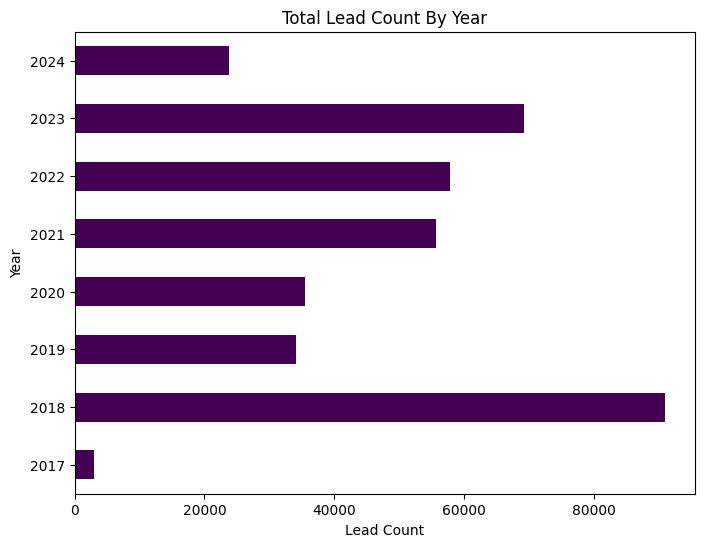

In [12]:
df[["lead_creat_yr", "is_creat"]]\
  .query("is_creat == 1 & lead_creat_yr >= 2017")\
    .groupby("lead_creat_yr")\
      .count()\
          .plot(kind="barh", xlabel="Lead Count", ylabel="Year", title="Total Lead Count By Year", colormap=list(colormaps)[3], legend=False)

Returns The Total Count Of Leads Grouped By Year, Month and Call Center 

In [13]:
df[["lead_creat_yr", "lead_creat_mnth_name", "cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby(["lead_creat_yr", "lead_creat_mnth_name", "cc_group"])\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})

Lead Count
lead_creat_yr lead_creat_mnth_name cc_group            
2014          Dec                  Sonstige           3
              Nov                  Sonstige           5
2015          Dec                  Sonstige           1
              Nov                  Sonstige           1
              Oct                  Sonstige           2
...                                                 ...
2024          Jan                  lfk             7390
              Mar                  KM Co            947
                                   Libify           636
                                   Sonstige          37
                                   lfk             5583

[413 rows x 1 columns]

Returns The Overall Lead Count By Month

<Axes: xlabel='Month', ylabel='Count'>

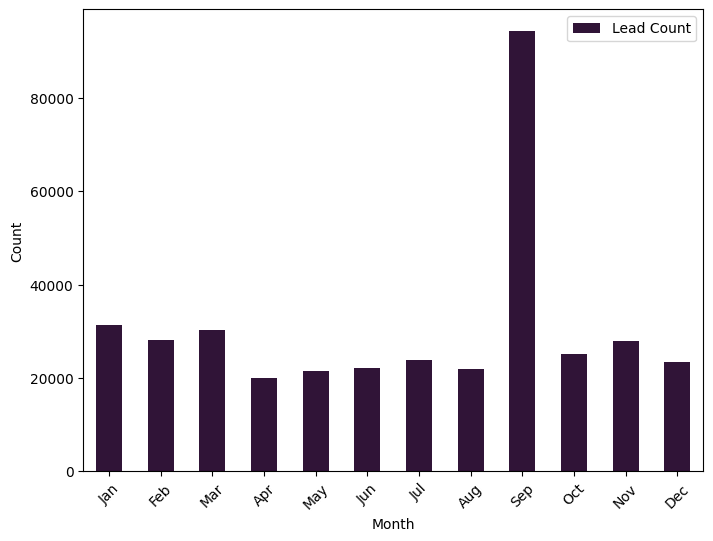

In [14]:
months_ordered = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]

df[["lead_creat_mnth_name", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_creat_mnth_name")\
      .count()\
        .reindex(months_ordered)\
          .rename(columns={"is_creat": "Lead Count"})\
            .plot(kind="bar", xlabel="Month", ylabel="Count", rot=45, colormap=list(colormaps)[6])

Returns Lead Count By Call Center

In [15]:
df[["cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("cc_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
cc_group                                
KM Co                              93783
lfk                                90326
Sonstige                           86879
Telepower                          36036
Covendos                           30871
Libify                             27439
Epfortuna                           3333
Comcare                             1396
Libify Owned and Operated/PM           2

<Axes: title={'center': 'Proportion Of Lead Count By Call Center'}, ylabel='Lead Count'>

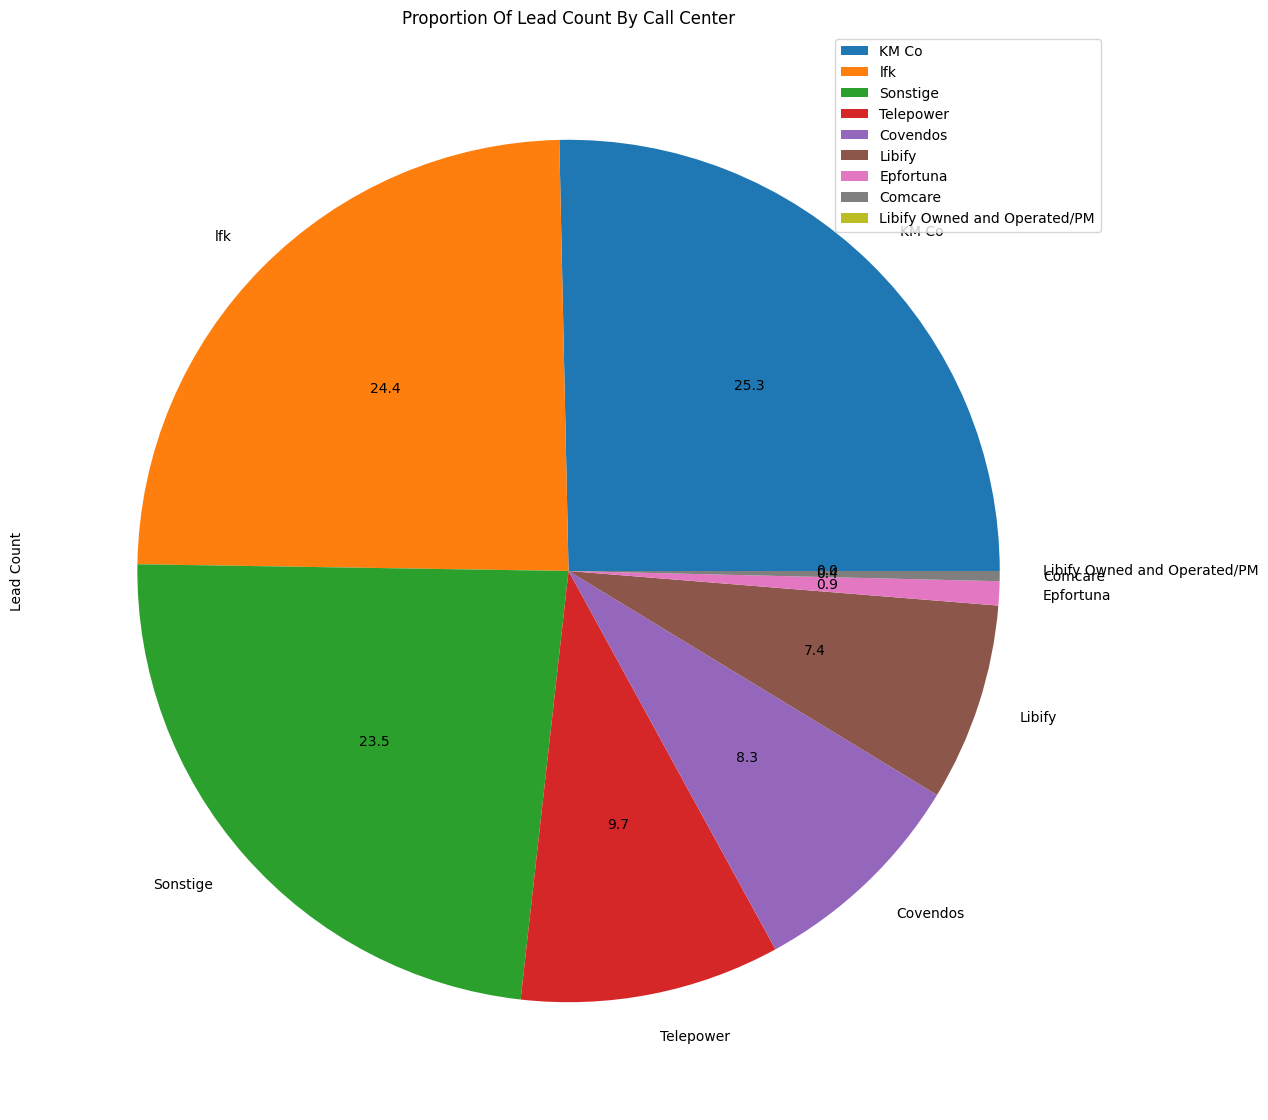

In [16]:
df[["cc_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("cc_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)\
            .plot(kind="pie", y="Lead Count", figsize=(20, 14), autopct="%.1f", title="Proportion Of Lead Count By Call Center")

Returns Lead Count By Lead Group

In [17]:
df[["lead_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
lead_group                       
Performance Marketing      257546
Online Extern               44335
Schrankfertig               28584
Organic Marketing           24598
Partner Marketing            4399
Offline Campaign             1533
Online Libify                  99
lokaler Markt                  39

In [18]:
df[["lead_group", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("lead_group")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=True)\
            .plot(kind="bar", xlabel="Lead Group", ylabel="Total Count", title="Lead Count By Lead Group", rot=45, colormap=list(colormaps)[9], figsize=(16, 6))

<Axes: title={'center': 'Lead Count By Lead Group'}, xlabel='Lead Group', ylabel='Total Count'>

Returns Lead Count By Campaign

In [19]:
df[["campaign", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("campaign")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)

Lead Count
campaign                                                      
Verband Pflegehilfe                                     124982
Käuferportal                                             39945
Pflege.de                                                28877
Hausfrage                                                26698
EP-Fortuna                                               24745
...                                                        ...
Matthias Delfs und Pasqual Stille GbR                        1
Pflegedienst Neef                                            1
Caritas-Sozialstation St. Franziskus e.V. Gemünden           1
Carekonzept Pfelgeberatung                                   1
DEIN Pflegedienst - Sören Nissen GbR                         1

[243 rows x 1 columns]

<Axes: title={'center': 'Lead Count By Campaign (Top 10)'}, xlabel='Campaign', ylabel='Lead Count'>

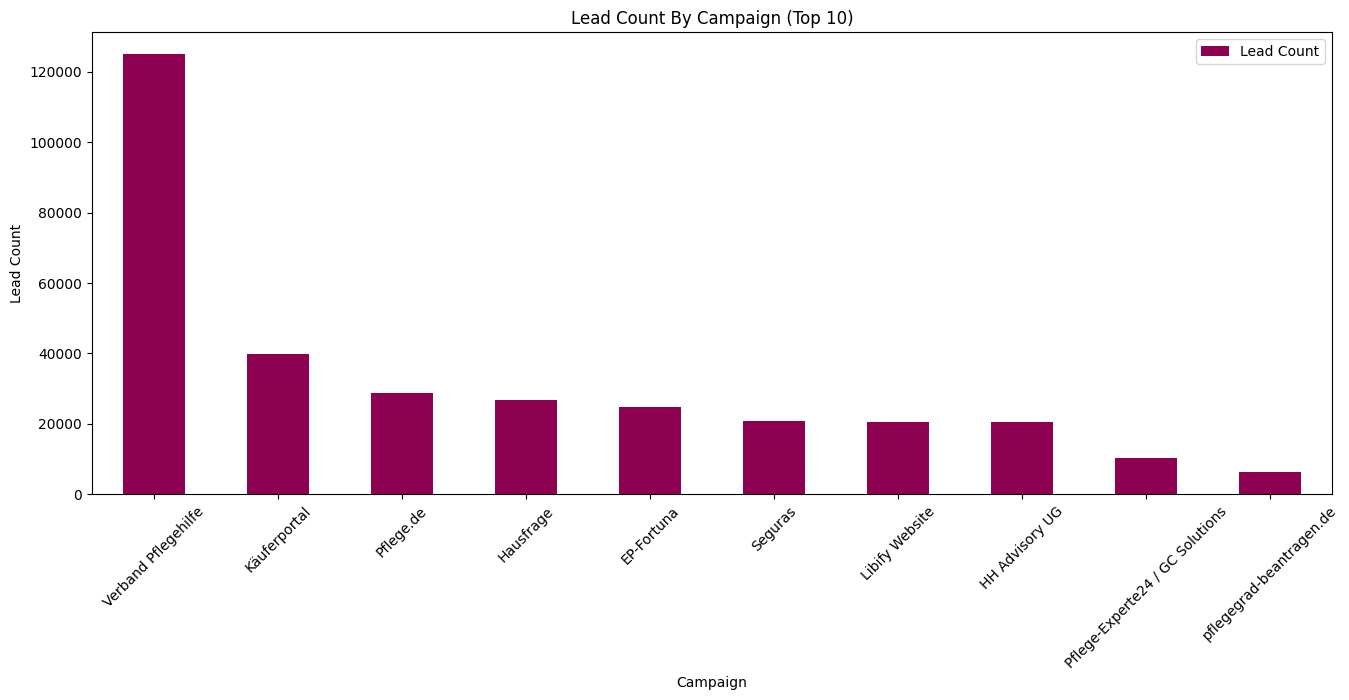

In [20]:
df[["campaign", "is_creat"]]\
  .query("is_creat == 1")\
    .groupby("campaign")\
      .count()\
        .rename(columns={"is_creat": "Lead Count"})\
          .sort_values(by="Lead Count", ascending=False)[:10]\
            .plot(kind="bar", xlabel="Campaign", ylabel="Lead Count", title="Lead Count By Campaign (Top 10)", rot=45, colormap=list(colormaps)[19], figsize=(16, 6))

# Feature Engineering

Step_1 ==> Select Columns To Use For Model Prediction\
Step_2 ==> Filter Only Qualified Leads And Cases Where Lead Was First Created, Thus Eliminate Duplicated Leads\
Step_3 ==> Sample Lead Created Dates On An Hourly Basis\
Step_4 ==> Sample Leads Created Beginning 1st January 2016 

In [21]:
is_lead_created = 1
lead_status = "qualified"
lead_created_date = '2016-01-01'
sampling_rule = "1H"
aggregates = {
               "aff_code": "nunique", 
               "cc_group": "nunique", 
               "lead_group": "nunique", 
               "campaign": "nunique", 
               "is_creat": "sum", 
               "is_acqui": "sum"
             }

fe_cols = ["lead_creat", "aff_code", "lead_status", "cc_group", "lead_group", "campaign", "is_creat", "is_acqui"]

df_fe = df[fe_cols]\
          .query("is_creat == @is_lead_created & lead_status == @lead_status & lead_creat >= @lead_created_date")\
            .set_index("lead_creat")\
              .resample(sampling_rule)\
                .agg(aggregates)\
                  .reset_index()

df_fe.head()

lead_creat  aff_code  cc_group  lead_group  campaign  is_creat  \
0 2016-01-10 00:00:00         1         1           1         1         1   
1 2016-01-10 01:00:00         0         0           0         0         0   
2 2016-01-10 02:00:00         0         0           0         0         0   
3 2016-01-10 03:00:00         0         0           0         0         0   
4 2016-01-10 04:00:00         0         0           0         0         0   

   is_acqui  
0         1  
1         0  
2         0  
3         0  
4         0

Step_5 ==> Check Missing Values For Feature DataFrame

In [22]:
df_fe.isnull().sum()

lead_creat    0
aff_code      0
cc_group      0
lead_group    0
campaign      0
is_creat      0
is_acqui      0
dtype: int64

<Axes: >

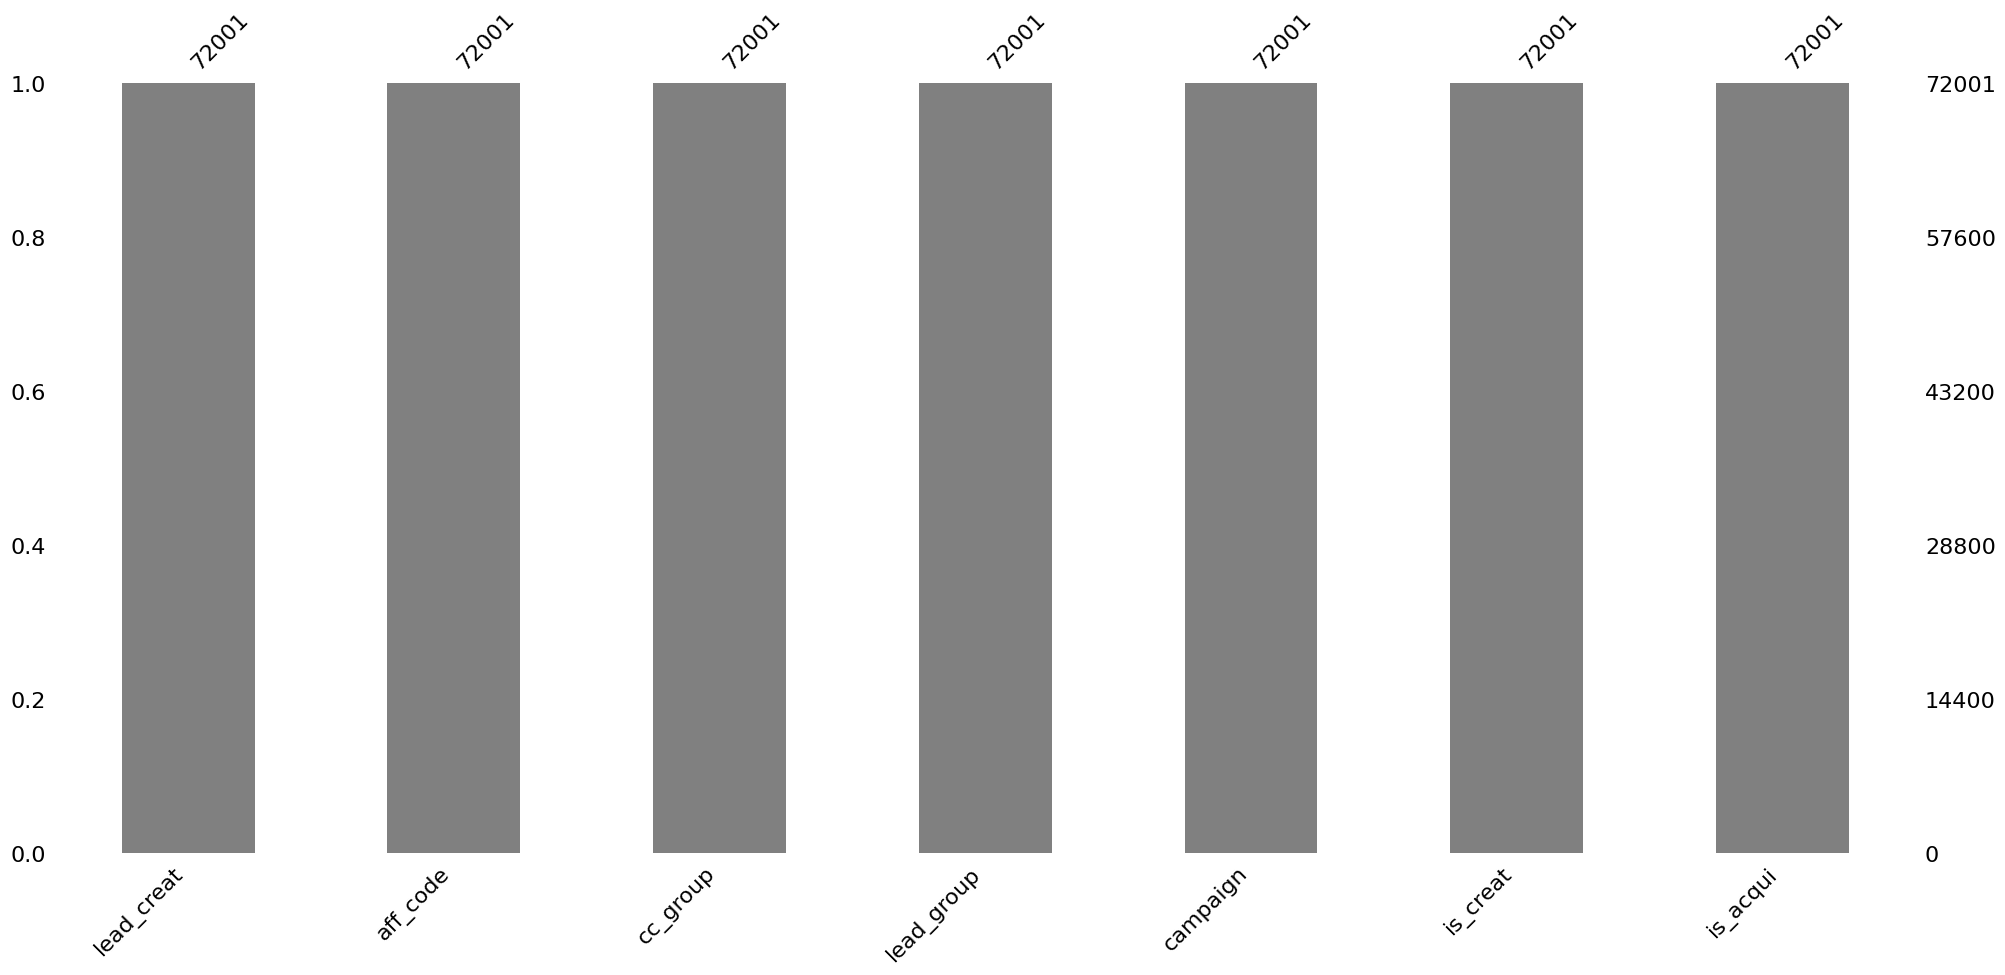

In [23]:
msno.bar(df_fe, color="grey")

Step_6 ==> Select Feature and Target Columns

In [24]:
feat_cols = ["lead_creat", "aff_code", "cc_group",	"lead_group",	"campaign",	"is_creat"]
tgt_col = "is_acqui"

df_feat = df_fe[feat_cols]     
df_tgt = df_fe[tgt_col]     

Step_7 ==> Split Data Into Training (50%), Validation (25%) and Testing (25%). Validation and Training data should be more recent than Training data

In [25]:
train_prop = 0.5
val_prop = 0.25

num_train_samples = int(train_prop * len(df_fe))
num_val_samples = int(val_prop * len(df_fe))
num_test_samples = len(df_fe) - num_train_samples - num_val_samples

print("num_train_samples:", num_train_samples)
print("num_val_samples:", num_val_samples)
print("num_test_samples:", num_test_samples)

num_train_samples: 36000
num_val_samples: 18000
num_test_samples: 18001


Step_8 ==> Normalize the data

In [26]:
# Transform Timestamp Using Fourier transform
timestamp_cols = ["lead_creat"]

# convert the date and time when the customer id was created to seconds
df_feat["timestamp_sec"] = df_feat[timestamp_cols].map(pd.Timestamp.timestamp)

# for subsequent stages of transformation, since subscriptions data deals with seasonality, it clearly has daily and yearly periodicity.
secs_in_day = 24 * 60 * 60
secs_in_year = np.multiply(365.2425, secs_in_day)

df_feat["day_sin"] = np.sin(df_feat["timestamp_sec"] * (2 * np.pi / secs_in_day))
df_feat["day_cos"] = np.cos(df_feat["timestamp_sec"] * (2 * np.pi / secs_in_day))
df_feat["year_sin"] = np.sin(df_feat["timestamp_sec"] * (2 * np.pi / secs_in_year))
df_feat["year_cos"] = np.cos(df_feat["timestamp_sec"] * (2 * np.pi / secs_in_year))

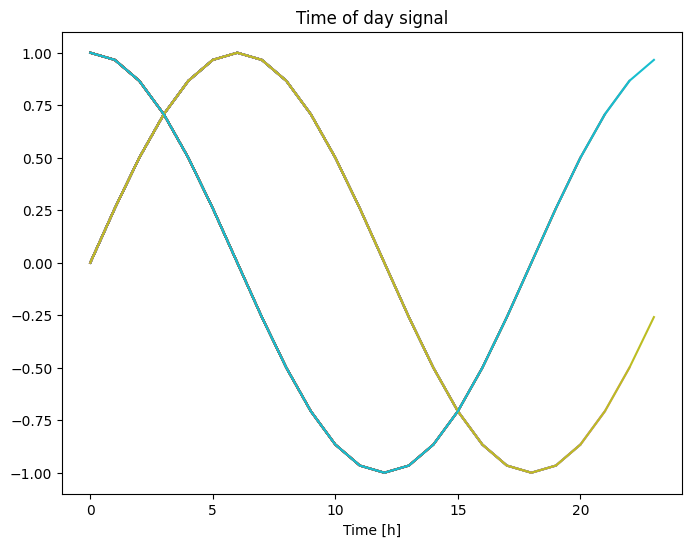

In [27]:
fig, ax = plt.subplots()

for _ in range(25):
    plt.plot(np.array(df_feat["day_sin"])[:_])
    plt.plot(np.array(df_feat["day_cos"])[:_])
    ax.set(title="Time of day signal", xlabel="Time [h]")

In [28]:
# numeric columns to scale
numeric_to_scale = ["aff_code",	"cc_group",	"lead_group",	"campaign",	"is_creat"]

# new column names to be assigned for numeric columns
numeric_trf_cols = ["aff_code_trf",	"cc_group_trf",	"lead_group_trf",	"campaign_trf",	"is_creat_trf"]

# assign new column names for transformed data
df_feat[numeric_trf_cols] = min_max_scaler(df_feat, numeric_to_scale)

# data scaled within a specific scale of 0 - 1
df_feat[numeric_trf_cols].describe().transpose()

count      mean       std  min  25%  50%  75%  max
aff_code_trf    72001.0  0.002565  0.016056  0.0  0.0  0.0  0.0  1.0
cc_group_trf    72001.0  0.020662  0.116497  0.0  0.0  0.0  0.0  1.0
lead_group_trf  72001.0  0.012620  0.071305  0.0  0.0  0.0  0.0  1.0
campaign_trf    72001.0  0.006758  0.041015  0.0  0.0  0.0  0.0  1.0
is_creat_trf    72001.0  0.000151  0.004432  0.0  0.0  0.0  0.0  1.0

<Axes: >

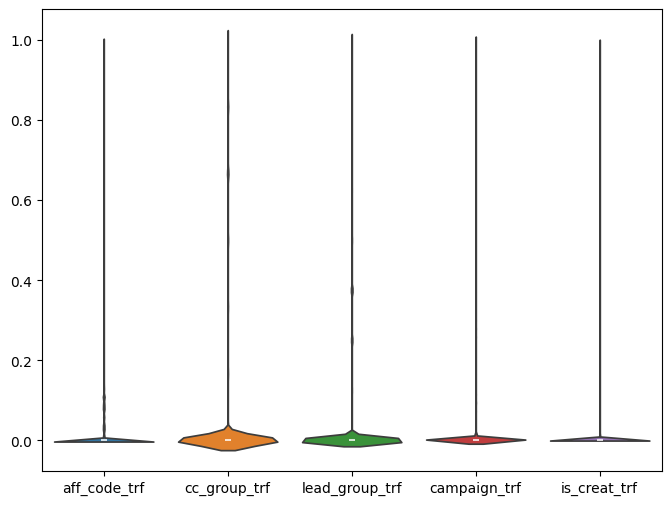

In [29]:
sns.violinplot(df_feat[numeric_trf_cols])

Step_9 ==> Instantiating datasets for training, validation, and testing

In [30]:
feat_cols_drop = ["lead_creat", "aff_code", "cc_group", "lead_group", "campaign", "is_creat", "timestamp_sec"]

df_feat = df_feat.drop(columns=feat_cols_drop)

In [31]:
sampling_rate = 1                                               # Observations will be sampled on an hourly basis (24 hours)
sequence_length = np.dot(24, 2)                                 # Observations will go back 2 days (46 hours) thus 24 * 2
delay = sampling_rate * (sequence_length + 24-1)                # The target for a sequence will be the customer acquisition 24 hours after the end of the sequence.
batch_size = 256                                                # Data size to pull for training at each iteration


train_dataset = window_dataset(df_feat[:-delay], targets=df_tgt[delay:], sequence_length=sequence_length, sampling_rate=sampling_rate, batch_size=batch_size, start_index=0, end_index=num_train_samples)
val_dataset = window_dataset(df_feat[:-delay], targets=df_tgt[delay:], sequence_length=sequence_length, sampling_rate=sampling_rate, batch_size=batch_size, start_index=num_train_samples, end_index=num_train_samples + num_val_samples)
test_dataset = window_dataset(df_feat[:-delay], targets=df_tgt[delay:], sequence_length=sequence_length, sampling_rate=sampling_rate, batch_size=batch_size, start_index=num_train_samples + num_val_samples)


# generate training, validation and test data on the fly (it would be wasteful to explicitly allocate memory for every sample)
X_train, y_train = train_dataset
X_val, y_val = val_dataset
X_test, y_test = test_dataset

samples shape: (256, 48, 9)
targets shape: (256,)
samples shape: (256, 48, 9)
targets shape: (256,)
samples shape: (256, 48, 9)
targets shape: (256,)


# Model Training & Evaluation

Layer Name: Dense Layer With Dropout

In [32]:
dense_dropout_model_history = model_pipeline(
                                              layers=[
                                                        keras.layers.Input(shape=(X_train.shape[1], X_train.shape[-1])),
                                                        keras.layers.Dense(512, activation="relu"),
                                                        keras.layers.Dropout(0.7),
                                                        keras.layers.Dense(256, activation="relu"),
                                                        keras.layers.Dropout(0.5),
                                                        keras.layers.Dense(128, activation="relu"),
                                                        keras.layers.Dropout(0.3),
                                                        keras.layers.Dense(1)
                                                     ],
                                              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                                              loss=keras.losses.MeanSquaredError(),
                                              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                              x=X_train,
                                              y=y_train,
                                              validation_data=(X_val, y_val),
                                              model_name=os.path.join(ml_output, "is_acquisition_dense_dropout.keras")
                                            )

Epoch 1/10
8/8 [==============================] - 2s 194ms/step - loss: 18.6604 - mean_absolute_error: 0.5531 - root_mean_squared_error: 4.3198 - val_loss: 44.1766 - val_mean_absolute_error: 1.2205 - val_root_mean_squared_error: 6.6465
Epoch 2/10
8/8 [==============================] - 2s 225ms/step - loss: 18.6519 - mean_absolute_error: 0.5579 - root_mean_squared_error: 4.3188 - val_loss: 44.1615 - val_mean_absolute_error: 1.2262 - val_root_mean_squared_error: 6.6454
Epoch 3/10
8/8 [==============================] - 1s 154ms/step - loss: 18.6520 - mean_absolute_error: 0.5628 - root_mean_squared_error: 4.3188 - val_loss: 44.1491 - val_mean_absolute_error: 1.2311 - val_root_mean_squared_error: 6.6445
Epoch 4/10
8/8 [==============================] - 1s 175ms/step - loss: 18.6414 - mean_absolute_error: 0.5619 - root_mean_squared_error: 4.3176 - val_loss: 44.1360 - val_mean_absolute_error: 1.2362 - val_root_mean_squared_error: 6.6435
Epoch 5/10
8/8 [==============================] - 1s 173

Layer Name: 1D convolutional model with Dropout

In [33]:
conv1D_dropout_model_history = model_pipeline(
                                                layers=[
                                                         keras.layers.Input(shape=(X_train.shape[1], X_train.shape[-1])),
                                                         keras.layers.Conv1D(8, 24, activation="relu"),
                                                         keras.layers.Dropout(0.5),
                                                         keras.layers.MaxPooling1D(2),
                                                         keras.layers.Dropout(0.5),
                                                         keras.layers.MaxPooling1D(2),
                                                         keras.layers.Dropout(0.5),
                                                         keras.layers.GlobalAveragePooling1D(),
                                                         keras.layers.Dropout(0.5),
                                                         keras.layers.Dense(1)
                                                       ],
                                                optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                                                loss=keras.losses.MeanSquaredError(),
                                                metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                                x=X_train,
                                                y=y_train,
                                                validation_data=(X_val, y_val),
                                                model_name=os.path.join(ml_output, "is_acquisition_conv1D_dropout.keras")
                                             )

Epoch 1/10
8/8 [==============================] - 1s 129ms/step - loss: 20.3907 - mean_absolute_error: 1.5081 - root_mean_squared_error: 4.5156 - val_loss: 44.5372 - val_mean_absolute_error: 1.4025 - val_root_mean_squared_error: 6.6736
Epoch 2/10
8/8 [==============================] - 1s 175ms/step - loss: 20.9852 - mean_absolute_error: 1.4714 - root_mean_squared_error: 4.5810 - val_loss: 44.5340 - val_mean_absolute_error: 1.4011 - val_root_mean_squared_error: 6.6734
Epoch 3/10
8/8 [==============================] - 1s 172ms/step - loss: 19.9580 - mean_absolute_error: 1.4702 - root_mean_squared_error: 4.4674 - val_loss: 44.5307 - val_mean_absolute_error: 1.4000 - val_root_mean_squared_error: 6.6731
Epoch 4/10
8/8 [==============================] - 2s 216ms/step - loss: 20.0005 - mean_absolute_error: 1.4005 - root_mean_squared_error: 4.4722 - val_loss: 44.5281 - val_mean_absolute_error: 1.3990 - val_root_mean_squared_error: 6.6729
Epoch 5/10
8/8 [==============================] - 1s 161

Recurrent Layers: SimpleRNN, LSTM, and GRU

In [34]:
lstm_dropout_model_history = model_pipeline(
                                              layers=[
                                                       keras.layers.Input(shape=(X_train.shape[1], X_train.shape[-1])),
                                                       keras.layers.LSTM(128, recurrent_dropout=0.25, return_sequences=True),
                                                       keras.layers.LSTM(128, recurrent_dropout=0.25, return_sequences=True),
                                                       keras.layers.LSTM(128, recurrent_dropout=0.25),
                                                       keras.layers.Dropout(0.5),
                                                       keras.layers.Dense(1)
                                                     ],
                                              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                                              loss=keras.losses.MeanSquaredError(),
                                              metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                              x=X_train,
                                              y=y_train,
                                              epochs=20,
                                              validation_data=(X_val, y_val),
                                              model_name=os.path.join(ml_output, "is_acquisition_lstm_dropout.keras")
                                           )

Epoch 1/20
8/8 [==============================] - 7s 495ms/step - loss: 18.6738 - mean_absolute_error: 0.5083 - root_mean_squared_error: 4.3213 - val_loss: 44.3686 - val_mean_absolute_error: 1.2270 - val_root_mean_squared_error: 6.6610
Epoch 2/20
8/8 [==============================] - 3s 386ms/step - loss: 18.6958 - mean_absolute_error: 0.5058 - root_mean_squared_error: 4.3239 - val_loss: 44.3604 - val_mean_absolute_error: 1.2257 - val_root_mean_squared_error: 6.6604
Epoch 3/20
8/8 [==============================] - 3s 397ms/step - loss: 18.7113 - mean_absolute_error: 0.5103 - root_mean_squared_error: 4.3257 - val_loss: 44.3514 - val_mean_absolute_error: 1.2240 - val_root_mean_squared_error: 6.6597
Epoch 4/20
8/8 [==============================] - 5s 640ms/step - loss: 18.6603 - mean_absolute_error: 0.4987 - root_mean_squared_error: 4.3198 - val_loss: 44.3441 - val_mean_absolute_error: 1.2231 - val_root_mean_squared_error: 6.6591
Epoch 5/20
8/8 [==============================] - 3s 360

Stacking recurrent layers with dropout

In [35]:
gru_dropout_model_history = model_pipeline(
                                            layers=[
                                                    keras.layers.Input(shape=(X_train.shape[1], X_train.shape[-1])),
                                                    keras.layers.GRU(128, recurrent_dropout=0.5, return_sequences=True),
                                                    keras.layers.GRU(128, recurrent_dropout=0.5, return_sequences=True),
                                                    keras.layers.Dropout(0.5),
                                                    keras.layers.Dense(1)
                                                  ],
                                            optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                                            loss=keras.losses.MeanSquaredError(),
                                            metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                            x=X_train,
                                            y=y_train,
                                            validation_data=(X_val, y_val),
                                            model_name=os.path.join(ml_output, "is_acquisition_gru_dropout.keras")
                                          )

Epoch 1/10
8/8 [==============================] - 4s 275ms/step - loss: 18.7075 - mean_absolute_error: 0.5202 - root_mean_squared_error: 4.3252 - val_loss: 44.3434 - val_mean_absolute_error: 1.2050 - val_root_mean_squared_error: 6.6591
Epoch 2/10
8/8 [==============================] - 2s 221ms/step - loss: 18.7014 - mean_absolute_error: 0.5154 - root_mean_squared_error: 4.3245 - val_loss: 44.3385 - val_mean_absolute_error: 1.2016 - val_root_mean_squared_error: 6.6587
Epoch 3/10
8/8 [==============================] - 2s 210ms/step - loss: 18.7142 - mean_absolute_error: 0.5136 - root_mean_squared_error: 4.3260 - val_loss: 44.3336 - val_mean_absolute_error: 1.1961 - val_root_mean_squared_error: 6.6583
Epoch 4/10
8/8 [==============================] - 2s 208ms/step - loss: 18.7011 - mean_absolute_error: 0.5123 - root_mean_squared_error: 4.3245 - val_loss: 44.3268 - val_mean_absolute_error: 1.1933 - val_root_mean_squared_error: 6.6578
Epoch 5/10
8/8 [==============================] - 2s 274

Layer Name: bidirectional RNNs with dropout

In [36]:
Bidirectional_dropout_model_history = model_pipeline(
                                                      layers=[
                                                               keras.layers.Input(shape=(X_train.shape[1], X_train.shape[-1])),
                                                               keras.layers.GRU(128, recurrent_dropout=0.25, return_sequences=True),
                                                               keras.layers.Bidirectional(keras.layers.LSTM(128)),
                                                               keras.layers.Dropout(0.5),
                                                               keras.layers.Dense(1)
                                                             ],
                                                      optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
                                                      loss=keras.losses.MeanSquaredError(),
                                                      metrics=[keras.metrics.MeanAbsoluteError(), keras.metrics.RootMeanSquaredError()],
                                                      x=X_train,
                                                      y=y_train,
                                                      validation_data=(X_val, y_val),
                                                      model_name=os.path.join(ml_output, "is_acquisition_bidirectional_RNN_dropout.keras")
                                                    )

Epoch 1/10
8/8 [==============================] - 6s 386ms/step - loss: 18.6798 - mean_absolute_error: 0.4938 - root_mean_squared_error: 4.3220 - val_loss: 44.3238 - val_mean_absolute_error: 1.1945 - val_root_mean_squared_error: 6.6576
Epoch 2/10
8/8 [==============================] - 2s 263ms/step - loss: 18.6322 - mean_absolute_error: 0.4916 - root_mean_squared_error: 4.3165 - val_loss: 44.3119 - val_mean_absolute_error: 1.1936 - val_root_mean_squared_error: 6.6567
Epoch 3/10
8/8 [==============================] - 3s 355ms/step - loss: 18.6770 - mean_absolute_error: 0.4894 - root_mean_squared_error: 4.3217 - val_loss: 44.3025 - val_mean_absolute_error: 1.1935 - val_root_mean_squared_error: 6.6560
Epoch 4/10
8/8 [==============================] - 2s 304ms/step - loss: 18.7215 - mean_absolute_error: 0.4931 - root_mean_squared_error: 4.3268 - val_loss: 44.2913 - val_mean_absolute_error: 1.1932 - val_root_mean_squared_error: 6.6552
Epoch 5/10
8/8 [==============================] - 2s 278

# Plot Model Results

<Axes: title={'center': 'Training and Validation MAE (bidirectional RNN) With Dropout'}, xlabel='Epochs', ylabel='Absolute error'>

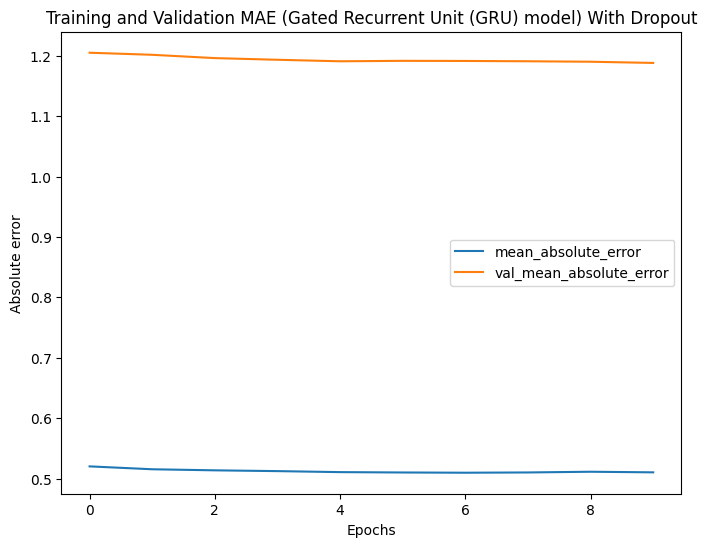

In [37]:
abs_error = ["mean_absolute_error", "val_mean_absolute_error"]
rmse_error = ["root_mean_squared_error", "val_root_mean_squared_error"]


plot_model_history(dense_dropout_model_history, abs_error, xlabel="Epochs", ylabel="Absolute error", title="Training and Validation MAE (Dense Layer With Dropout)")  
plot_model_history(conv1D_dropout_model_history, abs_error, xlabel="Epochs", ylabel="Absolute error", title="Training and Validation MAE (1D convolutional model With Dropout)") 
plot_model_history(lstm_dropout_model_history, abs_error, xlabel="Epochs", ylabel="Absolute error", title="Training and Validation MAE (Long Short Term Memory (LSTM) model) With Dropout")  
plot_model_history(gru_dropout_model_history, abs_error, xlabel="Epochs", ylabel="Absolute error", title="Training and Validation MAE (Gated Recurrent Unit (GRU) model) With Dropout")  
plot_model_history(Bidirectional_dropout_model_history, abs_error, xlabel="Epochs", ylabel="Absolute error", title="Training and Validation MAE (bidirectional RNN) With Dropout")  

# Model Evaluation

Compute loss value & metrics values for the test model

In [38]:
best_model_summary = evaluate_test_model("is_acquisition_lstm_dropout.keras", X_test, y_test)

8/8 [==============================] - 1s 31ms/step - loss: 38.6441 - mean_absolute_error: 1.2300 - root_mean_squared_error: 6.2164


Calculate model accuracy

In [39]:
df_ytrue_ypred = compute_model_metrics("is_acquisition_lstm_dropout.keras", y_test, X_test)
df_ytrue_ypred

8/8 [==============================] - 1s 34ms/step


y_true  y_pred is_correct
0       0.0     0.0        Yes
1       0.0     0.0        Yes
2       0.0     0.0        Yes
3       0.0     0.0        Yes
4       0.0     0.0        Yes
..      ...     ...        ...
251     0.0     0.0        Yes
252     0.0     0.0        Yes
253     0.0     0.0        Yes
254     0.0     0.0        Yes
255     0.0     0.0        Yes

[256 rows x 3 columns]

In [40]:
df_ytrue_ypred["is_correct"].value_counts()

is_correct
Yes    243
No      13
Name: count, dtype: int64

<Axes: title={'center': 'Test Data Evaluation'}, xlabel='Is Correct', ylabel='Count'>

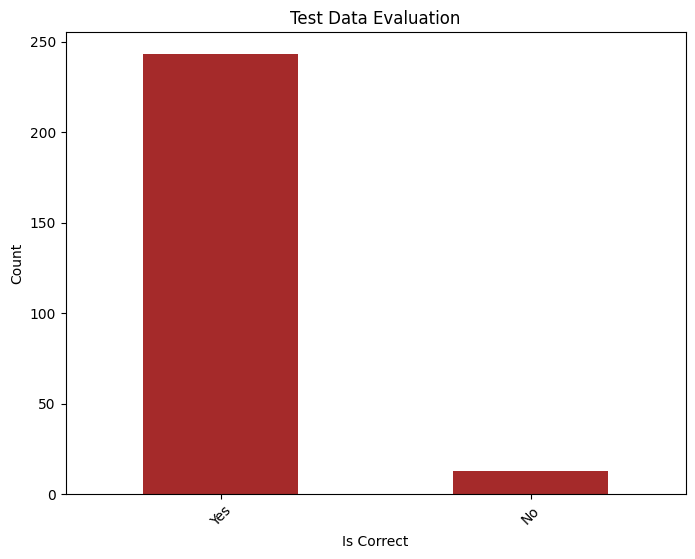

In [41]:
df_ytrue_ypred["is_correct"].value_counts().plot(kind="bar", xlabel="Is Correct", ylabel="Count", title="Test Data Evaluation", rot=45, color="brown")

In [42]:
round(df_ytrue_ypred["is_correct"].value_counts(normalize=True), 2)

is_correct
Yes    0.95
No     0.05
Name: proportion, dtype: float64

<Axes: title={'center': 'Test Data Evaluation (Proportion)'}, ylabel=' '>

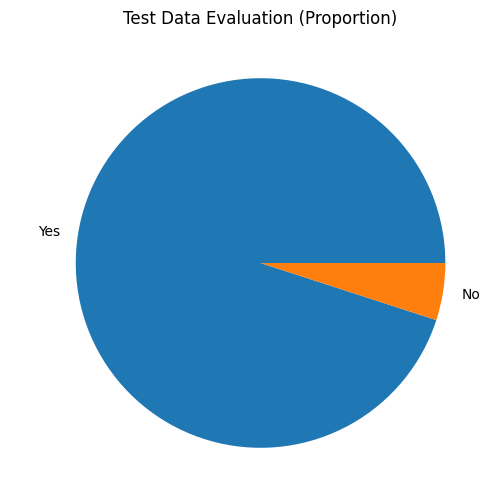

In [43]:
round(df_ytrue_ypred["is_correct"].value_counts(normalize=True), 2).plot(kind="pie", ylabel=" ", title="Test Data Evaluation (Proportion)")